# Utilizing Observations to Create Application Characterization
Workflow:  
1. Gather Context starting with recording build options and run options.
2. Decide on Important part(s) of Application to Analyze.
3. Gather Observations with HPCToolkit *(Short HPCToolkit Guide at Bottom)* alongside Context.
4. Perform Analysis.

### Gather Application Context
1. Build
    * Record Compiler Version: `gcc -v`
    * Record Optimization Flags: eg. `-O3 -ffast-math -march=native`
    * Record Dependent Library Versions?: `ldd -v [.exe]` 
    * Check for Compiler Specific Source Code Pragmas
        * Check to see what compile definitions in the build system are doing (-DINTEL)
        ```
        #ifdef INTEL
        #pragma simd
        #endif
        ```
        * Look Directly for `#pragma`'s in Source Code: `grep -B 3 -A 3 "#pragma" ./*`
2. Run
    * Record Number of Threads
    * Record Application Run Options Used

### Create Application Characterization from Observations
1. <a href=#Scaling>Scaling</a>  
2. <a href=#IPC>Instructions per Cycle</a>  
3. <a href=#MemoryBound>Memory Characteristics</a>  




---
<a name='Scaling'/></a>
# Scaling and Important Code Sections
### Gather Machine Information
`lstopo-no-graphics`  **or** `vim /proc/cpuinfo`  
Number of Cores: 18 Cores per Socket \* 2 Sockets = 36 Cores  
Number of Sockets: 2  
Number of Threads: 36 Cores \* 2 Threads per Core = 72 Threads (Hyperthreading)  



### Gather Time Observations
Measure time for 1 thread. 
```
export OMP_NUM_THREADS=1
hpcrun -e CPUTIME -o TimeMeasurements/1Thread <.exe> [application options]
hpcstruct <.exe>
hpcprof -S <.exe>.hpcstruct -I /Path/to/Src -o outputDatabase TimeMeasurements/*
hpcviewer outputDatabase
```
1 Thread Time = 8.95e+07 usec * 1e+06 usec/sec =  __88.6 seconds__
  
**or**
```
export OMP_NUM_THREADS=1
time <.exe> [application options]
```
Repeat for different number of threads changing OMP_NUM_THREADS and **output name**

In [74]:
# Conversion Constant
USEC_per_SEC = 1e+6

# Map to hold measured exe time. Key = # of Threads
TIME = {}
TIME['1'] = 8.86e+07 / USEC_per_SEC
TIME['2'] = (1.14e+08 / 2) / USEC_per_SEC
TIME['4'] = (1.26e+08 / 4) / USEC_per_SEC
TIME['8'] = (2.06e+08 / 8) / USEC_per_SEC
TIME['18'] = (3.37e+08 / 18) / USEC_per_SEC
TIME['36'] = (6.38e+08 / 36) / USEC_per_SEC # 1 Thread per Core
TIME['72'] = (1.04e+09/ 72) / USEC_per_SEC # 2 Threads per Core

### Calculate Perfect Scaling Baseline

In [75]:
# Map to hold perfect scaling exe time
PerfectTIME = {}
# Calculate Perfect Scaling Baseline: Execution Time on 1 Thread / Number of Threads
for key in TIME.keys():
    PerfectTIME[key] = TIME['1'] / int(key)

### Compare Observed with Perfect

In [76]:
#imports for Graphing
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

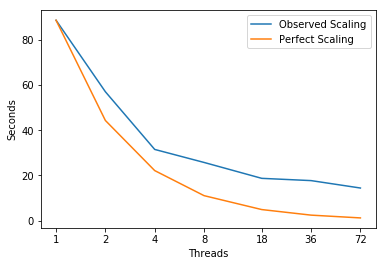

In [77]:
# Plot Measurements
Threads = [1,2,4,8,18,36,72]
fig, ax = plt.subplots(); ax.set_xscale('log', basex=2); ax.set_xticks(Threads)
ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax.plot(Threads, list(TIME.values()), label='Observed Scaling')
ax.plot(Threads, list(PerfectTIME.values()), label='Perfect Scaling')
ax.legend(); ax.set_xlabel('Threads'); ax.set_ylabel('Seconds')
plt.show()

## Decide on the Important Sections of the Code
While in HPCViewer navigate to find sections of code where time is spent.  HPCViewer supplies built in 'Hot Path' tool.  

![](assets/HPCToolkitHotPath.png)

---
<a name='IPC'/></a>
# Instructions per Cycle

### Gather Machine Information
Agner.org or Documentation
Maximum throughput for architecture pipeline = **4**  
  
*Notes:*
1. *Based on decoding 2 instructions per cycle with possibility of fused instructions*
2. *Instruction Microcache can hold decoded instructions*

**Two Instructions per Cycle per Core is more realistic baseline**

### Observe Instructions per Cycle
```
hpcrun  -e PAPI_TOT_INS -o IPCMeasurements <.exe> [application options]
hpcstruct <.exe>
hpcprof -S <.exe>.hpcstruct -I /path/to/src -o IPCDatabase IPCMeasurements
hpcviewer IPCDatabase
```

In [1]:
# Machine Information
Threads = 72
Cores = 36
Instructions_per_Cycle_per_Core_Baseline = 2
Mhz = 2301.0

# Conversion Constants
MicroSeconds_per_Second = 1000000
Cycles_per_Second_per_Mhz = 1000000

# HPCToolkit Measurements
Total_Instructions = 5.60e+11
# From TimeDatabase
CPUTIME = 1.04e+09

# Application Run Cycles
Application_MicroSeconds = CPUTIME / Threads # usec # CPUTIME counted on each thread
Total_Secs = (Application_MicroSeconds / MicroSeconds_per_Second) # sec
Cycles_per_Second = Mhz * Cycles_per_Second_per_Mhz
Total_Cycles = Total_Secs * Cycles_per_Second

# Instructions per Cycle
Instructions_per_Cycle = Total_Instructions / Total_Cycles
Instructions_per_Cycle_Baseline = Instructions_per_Cycle_per_Core_Baseline * Cores
Instructions_per_Cycle_per_Core = Instructions_per_Cycle / Cores

print('{:.4} Instructions per Cycle with {} IPC Baseline'.format(
    Instructions_per_Cycle, Instructions_per_Cycle_Baseline))
print('{:.2f}% of Baseline'.format((Instructions_per_Cycle / Instructions_per_Cycle_Baseline) * 100))
print('{:.2} Inst/Cyc per Core'.format(Instructions_per_Cycle_per_Core))

16.85 Instructions per Cycle with 72 IPC Baseline
23.40% of Baseline
0.47 Inst/Cyc per Core


### Analyze
*If Instructions per Cycle is Around or Above Baseline, Application is Likely Compute Bound. Consider the how close the Application is to Being Bound on Bandwidth. Determine how much room for improvement hardware core has.* 

---
<a name='MemoryBound'/></a>
# Memory Characteristics 
---

## L1 Bandwidth

L1 Cache: L1 can do partial loads, cannot assume full cacheline. Look to see how many loads/cycle are being completed: `L1_Hit_Rate * LD_Instructions / Application_Cycles = L1_Loads_per_Cycle` vs. # Load Ports Available

### Gather Machine Information
Agner.org or Documetation  
**Number of Load Ports per Core = 2**

### Observe L1 Loads
```
hpcrun -e PAPI_L1_DCM -e PAPI_LD_INS -e PAPI_SR_INS \
       -o L1LoadMeasurments <.exe> [application options]
hpcstruct <.exe>
hpcprof -S <.exe>.hpcstruct -I /path/to/src -o L1LoadDatabase measurementDirectory
hpcviewer L1LoadDatabase
```
### Calculate L1 Loads per Cycle


In [2]:
# Machine Information
Threads = 72
Cores = 36
Load_Ports_per_Core = 2
Total_Load_Ports = Load_Ports_per_Core * Cores
Mhz = 2301.0

# Conversion Constants
MicroSeconds_per_Second = 1000000
Cycles_per_Second_per_Mhz = 1000000

# Measurements from HPCToolkit
PAPI_LD_INS = 4.22e+11
PAPI_SR_INS = 3.68e+10
PAPI_L1_DCM = 2.12e+10
# From TimeDatabase
CPUTIME = 1.04e+09 # usec

# Convert Time to Cycles
Application_MicroSeconds = CPUTIME / Threads # usec 
Application_Secs = (CPUTIME / MicroSeconds_per_Second) # sec
Cycles_per_Second = Mhz * Cycles_per_Second_per_Mhz # cycles/sec
Total_Cycles = Total_Secs * Cycles_per_Second # cycles

# Analysis
L1_Miss_Rate = PAPI_L1_DCM / (PAPI_LD_INS + PAPI_SR_INS)
L1_Loads = PAPI_LD_INS * (1 - L1_Miss_Rate)
L1_Loads_per_Cycle = L1_Loads / Total_Cycles 
print('L1 Data Cache Miss Rate: {:.2}%'.format(L1_Miss_Rate))
print('{:.3} Loads per Cycle with {} Load Ports'.format(L1_Loads_per_Cycle, Total_Load_Ports))
print('{:.3} Loads per Cycle per Core'.format(L1_Loads_per_Cycle/ Cores))

L1 Data Cache Miss Rate: 0.046%
12.1 Loads per Cycle with 72 Load Ports
0.336 Loads per Cycle per Core


### Analyze
*If L1 Loads per Cycle Close to Maximum Possible then Investigate Size of the L1 Loads.  May need to vectorize.*  

---
## Memory Bandwidth beyond L1 Cache

1. <a href=#Roofline>Measure system with Empirical Roofline Toolkit</a>
2. <a href=#HPCToolkit>Measure application with HPCToolkit</a>
3. <a href=#Analyze>Analyze the data</a>

<a name='Roofline'/></a>
### 1. Measure the System with Empirical Roofline ToolKit
```
git clone https://bitbucket.org/berkeleylab/cs-roofline-toolkit.git
cd cs-roofline-toolkit/Empirical_Roofline_Tool-1.1.0
```
Edit/Rename existing config file in Config directory 
```
./ert /Path/to/your/config.file
```
View the .ps file in the results directory
![](assets/roofline.png)
#### Extract the Data

In [28]:
# Data From Roofline # B/W with 72 Threads
Roofline_Bandwidth = {}
Roofline_Bandwidth['L1'] = 2399.9 # GB/s
Roofline_Bandwidth['L2']  = 784.0 # GB/s
Roofline_Bandwidth['L3']  = 564.8 # GB/s
Roofline_Bandwidth['DRAM']  = 60.4 # GB/s

#### Collect Additional System Data

In [43]:
# Collect information from other sources
BYTES_per_CACHELINE = 64
Threads = 72

<a name='HPCToolkit'/></a>
### 2. Measure the Application with HPCToolkit
#### Choose Desired Events and Measure
```
hpcrun -e PAPI_L1_DCM -e PAPI_L2_DCM -e PAPI_L2_ICM -e PAPI_L3_TCM \
    -o BWMeasurements <.exe> [application options]
hpcrun -e PAPI_TOT_CYC -e PAPI_LD_INS -e PAPI_SR_INS \
    -o BWMeasurements <.exe>
hpcstruct <.exe>
hpcprof -S <.exe>.hpcstruct -I /Path/to/Src/'+' -o BWDatabase BWMeasurements
hpcviewer BWDatabase
```

<a name='Analyze'/></a>
### 3. Analyze the Data

In [60]:
# Measurements from HPCToolkit

# TODO: Discuss the various ways to count this?
BW_Used = {}
BW_Used['L2'] = L1_misses = 2.12e+10 # Cachelines
BW_Used['L3'] = L2_misses = 1.41e+10 # Cachelines
BW_Used['DRAM'] = L3_misses = 1.63e+09 # Cachelines 

CPUTIME = 1.04e+09

In [65]:
# Cache Miss Rates
L2_Miss_Rate = L2_misses / L1_misses 
L3_Miss_Rate = L3_misses / L2_misses
print('L2 Data Cache Miss Rate: {:.2f}%'.format(L2_Miss_Rate * 100))
print('L3 Data Cache Miss Rate: {:.2f}%'.format(L3_Miss_Rate * 100))

L2 Data Cache Miss Rate: 66.51%
L3 Data Cache Miss Rate: 11.56%


In [62]:
# Conversion Constants
BYTES_per_GB = 1073741824
MicroSeconds_per_Second = 1000000

In [63]:
# Do Some Conversions

# Measured Cycles to Seconds
Application_MicroSeconds= CPUTIME / Threads # Total Cycles counted on each thread
Application_Seconds = Application_MicroSeconds / MicroSeconds_per_Second

# Convert HPCToolkit Measurement to GB/sec
# Cachelines to Bytes to GBs / Cycles to sec
for CacheName, Cachelines in BW_Used.items():
    Bytes_Used = Cachelines * BYTES_per_CACHELINE # Bytes
    GB_Used = Bytes_Used / BYTES_per_GB # GBs
    Application_BW = GB_Used / Application_Seconds # GB/sec

    # Compare with roofline results
    Utilization = Application_BW / Roofline_Bandwidth[CacheName]
    print('{} Bandwidth Used: {:.2f}%'.format(CacheName, Utilization * 100))

L2 Bandwidth Used: 11.16%
L3 Bandwidth Used: 10.30%
DRAM Bandwidth Used: 11.14%


### Analyze
*If bandwidth utilization is low, but application is bound on memory then most likely bound by memory latency.*

---
# Using HPCToolkit
#### Build Application with Debug Symbols and Optimization Options
```
clang -g -O3 ...
```
#### To View Available Events:  
`hpcrun -L <.exe>`
![](assets/hpcrunList.png)

---

### Basic HPCToolkit Workflow
#### 1. Choose Desired Events and Measure
```
hpcrun -e <eventName1> -e <eventName2> ... -e <eventNameN> \
    -o MeasurementDirectory <.exe> [application options]
```
Repeat `hpcrun` as needed to collect all desired measurements.  
  
**Notes:**
1. *When collecting same measurement into same measurement directory it sums them into one value.*
3. *Cycles and Time is counted on each thread*
4. *Some events may conflict without proper error message*

#### 2. Build Binary Structure File
```
hpcstruct <.exe>
```
*Notes:*
1. *Only need to run hpcstruct once*

#### 3. Build HPCToolkit Database
```
hpcprof -S <.exe>.hpcstruct -I /Path/to/Src/'+' -o OutputDirectory MeasurementDirectory
```
*Notes:*   
1. *'+' Recursively Searches that Directory*  
2. *May include multiple `-I` arguments and multiple MeasurementDirectories*

#### 4. View HPCToolkit Database
```
hpcviewer OutputDirectory
```

